In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 3


# Train model 

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 4s 9us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0044 - val_acc: 0.9991


# Learning curves

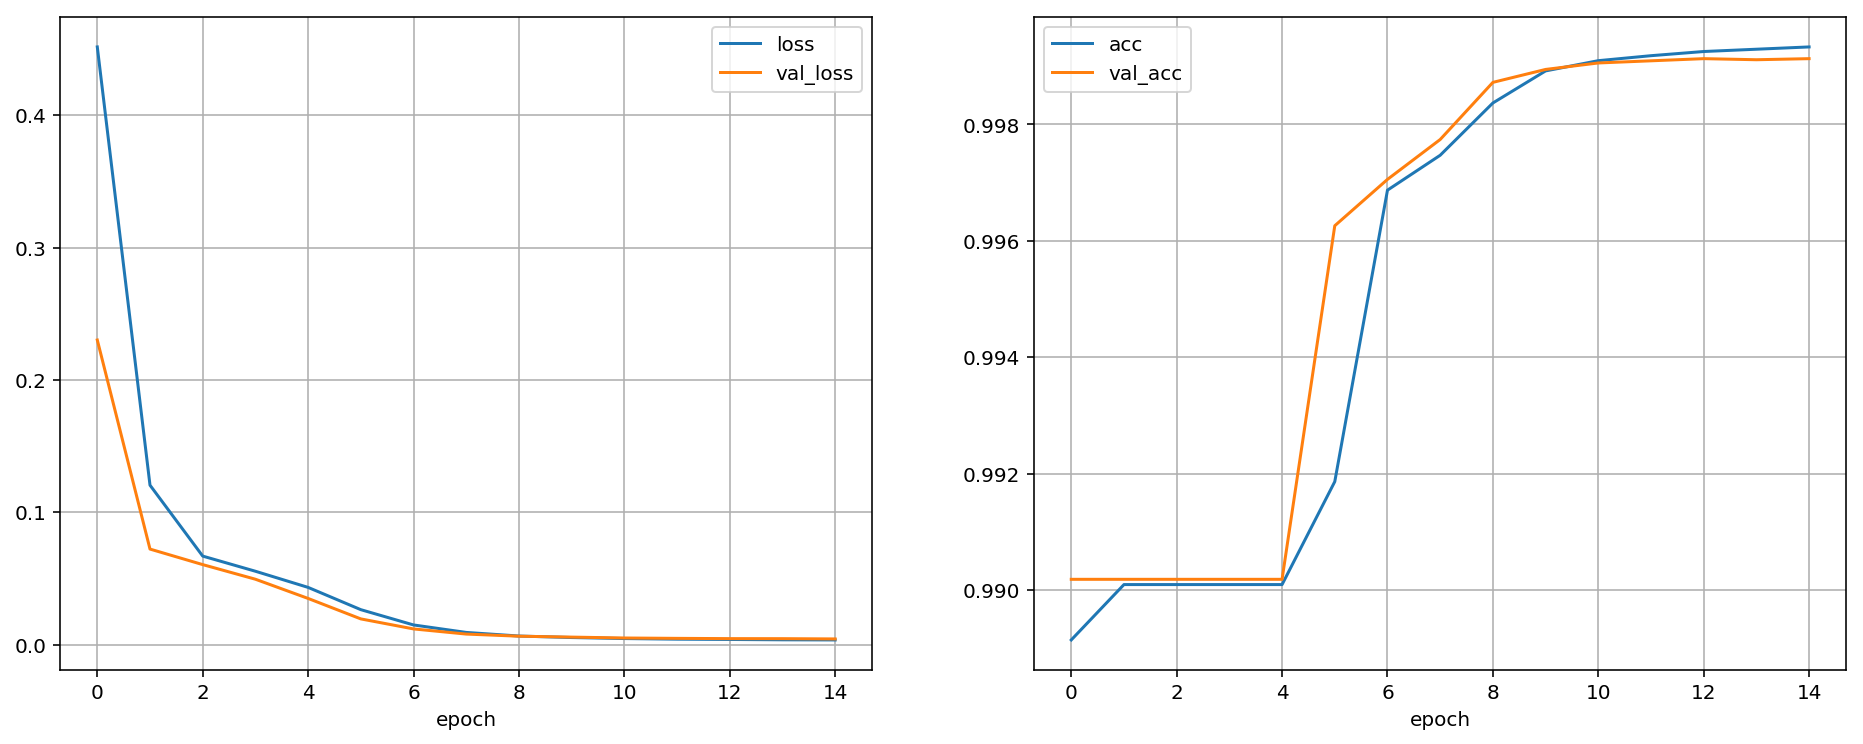

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [28]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.99      0.92      0.95       530

avg / total       1.00      1.00      1.00     54004

[[53468     6]
 [   41   489]]


In [29]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
23432,conf/sigmod/OlstonJW03,adaptive filters for continuous queries over distributed data streams,olston jiang widom,sigmod conference,2003,fW0CpIqoV7QJ,widomj 2003 adaptivefiltersforcontinuous queries over distributed data streams,jj olstonc,proceedings of acm sigmod,0.0
15358,conf/vldb/HuebschHLLSS03,querying the internet with pier,huebsch hellerstein lanham loo shenker stoica,vldb,2003,QfqykiFRwyYJ,querying the inernet withpier,huebsch lanham loo hellerstein,proceedings of 29th international conference on very large,0.0
30812,conf/vldb/KiesslingK02,preference sql design implementation experiences,kießling köstler,vldb,2002,3VHepuiTGHUJ,preference implementation,ling kostler,technical report october,0.0
17181,journals/sigmod/CasatiDS00,vldb workshop on technologies in tes,nan,nan,2000,pJsnj7fi9LIJ,report on the vldb workshop on technologies for tes cairo egypt september 14 and 15,casati,sigmod record,2000.0
48992,journals/sigmod/GatziuKBF98,unbundling active functionality,gatziu koschel bültzingsloewen fritschi,sigmod record,1998,H1JxB_3PZy4J,1998 unbundling active functionality,,acm sigmod,0.0


# Save model and histories 

In [30]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-1')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99938   0.99996   0.99967     53467
          1    0.99606   0.93866   0.96651       538

avg / total    0.99935   0.99935   0.99934     54005

[[53465     2]
 [   33   505]]
